In [ ]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
# save an image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

  return PIL.Image.fromarray(tensor)

In [ ]:
# load an image 
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32) #[0, 1]

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :] #(bs, H, W, C)

  return img

In [ ]:
# show an image
def imshow(image, title=None):
  plt.imshow(image)
  if title:
    plt.title(title)

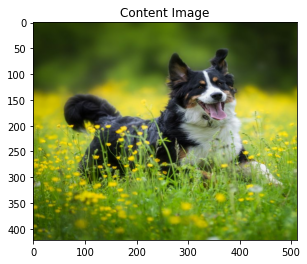

In [ ]:
content_image = load_img("/content/drive/MyDrive/ProjectII/Images/dog.jpg")
imshow(content_image[0], 'Content Image')

In [ ]:
# model 
vgg = tf.keras.applications.VGG19(include_top=False,
                                  weights='imagenet',
                                  input_shape=(422, 512, 3))

vgg.trainable= False
outputs = [vgg.get_layer('block5_conv1').output, vgg.get_layer('block5_conv2').output]

model = tf.keras.Model([vgg.input], outputs)

In [ ]:
# test 
data = tf.random.normal((1, 422, 512, 3))
fms = model(data)

print(type(fms))
for fm in fms:
  print(fm.shape)

<class 'list'>
(1, 26, 32, 512)
(1, 26, 32, 512)


In [ ]:
# Create a model
def get_vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False,
                                    weights='imagenet')
  
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
# Create the model
content_layers = ['block3_conv2',
                  'block4_conv2',
                  'block5_conv2']
num_content_layers = len(content_layers)
my_net = get_vgg_layers(content_layers)

def compute_feature(inputs):
  inputs = inputs*255.0
  preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
  content_outputs = my_net(preprocessed_input)

  return content_outputs

In [ ]:
# Compute for target image
content_targets = compute_feature(content_image) # feature maps for target

In [ ]:
type(content_targets)

list

(1, 422, 512, 3)


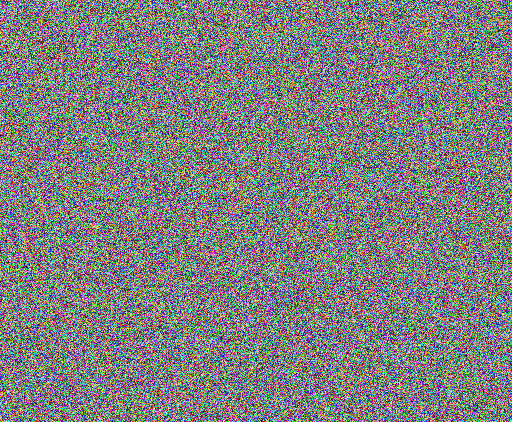

In [ ]:
image = tf.Variable(tf.random.uniform(content_image.shape,
                                      minval=0,
                                      maxval=1))

print(image.shape)

def clip_0_1(image):
  return tf.clip_by_value(image,
                          clip_value_min=0.0,
                          clip_value_max=1.0)
  
display.display(tensor_to_image(image[0]))

In [ ]:
# optimizer 
opt = tf.optimizers.Adam(learning_rate=0.01,
                         beta_1=0.99,
                         epsilon=1e-1)

# content_loss
def content_loss(content_outputs):
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[i]-content_targets[i])**2) 
                             for i in [0, 1, 2]])
  loss = content_loss / num_content_layers
  return loss

In [ ]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = compute_feature(image)
    loss = content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

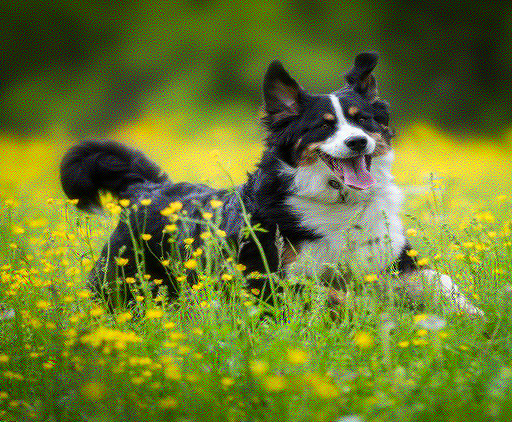

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train step: 10000


In [ ]:
epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image[0]))
  if(step == 100 or step == 500 or step == 1000 or step == 2000 or step == 3000 or step == 5000 or step == 10000):
    file_name = 'content_loss_3L_{}_epochs.png'.format(step/100)
    tensor_to_image(image[0]).save(file_name)

    try:
      from google.colab import files
    except ImportError:
      pass
    else:
      files.download(file_name)
  print("Train step: {}".format(step))

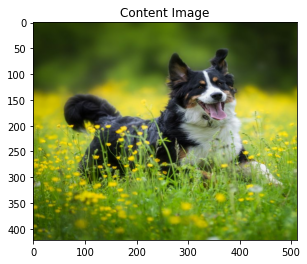

In [ ]:
imshow(content_image[0], 'Content Image')